In [33]:
%matplotlib inline

import json
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import util
from skimage import io
from skimage import exposure
from skimage import morphology
from skimage import measure
from skimage import filters
from skimage import registration
from skimage import transform
from skimage import color
from skimage import feature
from sklearn import metrics
from skimage import draw

# Drawing functions use (row, cols) coords, transformation functions use (x, y) coords

PATH='../spotGEO/'

def read_annotation_file(path):
    '''This creates a dictionary where the first key is the sequence id,
    and the second key is the frame id, which contains a list of the 
    annotation points as lists of floating numbers.
    For example sequence #1 shown above contains 3 objects, which are visible in both frames #1 and #3.'''
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict


def get_sequence(seqid):
    frames = [util.img_as_float(io.imread(f"../spotGEO/test/{seqid}/{i+1}.png", as_gray=True)) for i in range(0, 5)]
    frames = np.array(frames)
    return frames


def get_targets(seqid):
    '''Returns array of n_objects x n_frames x coords'''
    return np.array([dataset[seqid][frame] for frame in dataset[seqid]]).swapaxes(0, 1)


def draw_circle(ax, r, c, radius, color):
    circle = plt.Circle((c, r), radius, color=color, fill=False)
    ax.add_artist(circle)

    
def draw_target(ax, r, c):
    draw_circle(ax, r, c, radius=10, color='r')
    
    
def draw_prediction(ax, r, c):
    draw_circle(ax, r, c, radius=10, color='g')
    
    
def extract_region(arr, r0, c0, radius):
    """ Returns the values within a radius of the given x, y coordinates """
    return arr[(r0 - radius) : (r0 + radius + 1), (c0 - radius) : (c0 + radius + 1)]


def filter_valid_regions(regions):
    return [region for region in regions if region.shape[0] == region.shape[1]]

def filter_valid(regions, coords):
    isel = [region.shape[0] == region.shape[1] and region.shape[0] != 0 for region in regions]

    regions = [regions[i] for i, cond in enumerate(isel) if cond]
    coords = coords[isel]    
    
    return regions, coords

def register(src, dst):
    shifts, _, _ = registration.phase_cross_correlation(src, dst, upsample_factor=100)
    # phase_cross_correlation returns y, x numpy coords, we flip it to x, y
    return transform.SimilarityTransform(translation=np.flip(shifts))


def evaluate_transform_matrix(frames):
    T1 = register(frames[1], frames[0])
    T2 = register(frames[2], frames[1])
    T3 = register(frames[3], frames[2])
    T4 = register(frames[4], frames[3])

    # Sometimes the transformation matrix may return outlier transformations
    # here we assume the same transformation matrix repeated for all the frames
    Q = np.array([T.params.ravel() for T in [T1, T2, T3, T4]])

    T = np.median(Q, axis=0).reshape(3,3)
    return T


def evaluate_transforms_to_frame2(frames):
    T = evaluate_transform_matrix(frames)
    return [T @ T, T, np.eye(3), np.linalg.inv(T), np.linalg.inv(T @ T)]


def transform_sequence_to_frame2(frames):
    Ts = evaluate_transforms_to_frame2(frames)
    return np.array([warp(frame, Ti) for Ti, frame in zip(Ts, frames)])


def warp(frame, T):
    return transform.warp(frame, np.linalg.inv(T))


def get_proposal(registered, frameid):
    Ibase = np.max(registered[np.arange(len(registered)) != frameid], axis=0)

    mask = (registered[frameid] > 0)
    Idiff = np.maximum((registered[frameid]*mask) - (Ibase), 0)
    
    # Find local maxima as x, y coords
    Imaxima = morphology.h_maxima(Idiff, 0.02, selem=morphology.diamond(5))    
    r, c = np.where(Imaxima > 0)
    coords = np.c_[c, r]

    return coords


def find_targets(arr, targets):
    ''' Find regions indices corresponding to target '''
    d = metrics.pairwise_distances(arr, targets)
    return np.argmin(d, axis=0)


def coords_from_binary(arr):
    r, c = np.where(arr > 0)
    return np.c_[c, r]


def remove_stars(registered, coords):
    ''' Remove stars and recompute coordinates '''
    Ifull = np.max(registered, axis=0)

    Imaxima = np.zeros(Ifull.shape, dtype='bool')
    Imaxima[coords[:, 1], coords[:, 0]] = 1.0

    Imask = Imaxima * (Ifull < 0.6)
    
    coords = coords_from_binary(Imask > 0)
    
    return coords

In [34]:
dataset = read_annotation_file(os.path.join(PATH, 'train_anno.json'))

print('Dataset contains', len(dataset), 'elements')

seqid = 15

def regions_from_sequence(seqid):
    regions = []
    
    frames = get_sequence(seqid)
    targets = get_targets(seqid)
    
    # Extract target regions

    n_objects = len(targets)
    
    for frameid, frame in enumerate(frames):
        for objid in range(n_objects):
            c0, r0 = targets[objid, frameid]
            region = extract_region(frame, int(r0 + 0.5), int(c0 + 0.5), 5)
            
            if region.shape[0] == 0 or region.shape[1] == 0 or region.shape[0] != region.shape[1]:
                continue
            
            label = np.zeros(region.shape)
            label[draw.disk((5, 5), 2)] = 1

            regions.append( (region, label) )

    # Add none regions
    h_max, w_max = frames[0].shape
    radius = 15
    offset = 30

    max_none = np.maximum(10, len(regions))
    
    S = np.random.uniform((radius, radius), (h_max - radius, w_max - radius), size=(max_none,2))
        
    # Remove coords close to target
    if len(regions) > 0:
        d = metrics.pairwise_distances(S, targets.reshape(-1, 2))
        S = S[np.all(d > offset, axis=1)]

    for r0, c0 in S:
        region = extract_region(frames[frameid], int(r0 + 0.5), int(c0 + 0.5), 5)
        label = np.zeros(region.shape)
        regions.append( (region, label) )

    return regions


regions = regions_from_sequence(seqid)

print(np.array(regions).shape)

Dataset contains 1280 elements
(15, 2, 11, 11)


N = 500
regions = []
for i, idx in enumerate(np.random.choice(len(dataset), size=N, replace=False)):
    print(i, "/", N)
    regions += regions_from_sequence(idx+1)

regions = np.array(regions)

print(regions.shape)

np.save('region-dataset-1.npy', regions)

regions = np.load('region-dataset.npy')

X = regions[:, 0, :]
y = regions[:, 1, :]

X = X.reshape(-1, X.shape[-1]*X.shape[-2])
y = y.reshape(-1, y.shape[-1]*y.shape[-2])

print(X.shape, y.shape)

from sklearn.model_selection import train_test_split
from sklearn import metrics

X = regions[:, 0, :]
y = regions[:, 1, :]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print(X_train.shape, X_test.shape)

X_train1 = X_train[..., None]
X_test1 = X_test[..., None]
y_train1 = y_train[..., None]
y_test1 = y_test[..., None]


print(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape)

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential() #add model layers
model.add(Conv2D(64, kernel_size=5, padding='same', activation='relu', input_shape=(None, None, 1)))
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(1, kernel_size=1, padding='same', activation='sigmoid'))

model.compile('adamax',
  loss='binary_crossentropy',
  metrics=['mse'],
)

model.summary()

# train the model
history = model.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs=10)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss')
plt.show()


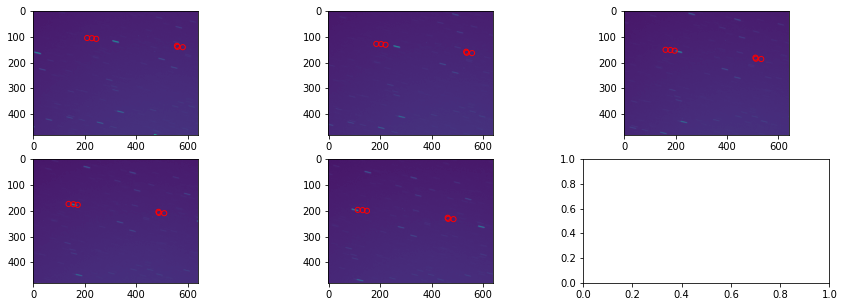

In [93]:
%matplotlib inline

from keras.models import load_model

# model2 = load_model('mainfilter-8-2.h5')
# model4 = load_model('mainfilter-73.h5')
model = load_model('mainfilter-1.h5')

# seqid = 120
# seqid = 1190
seqid = 760
# seqid = 135
# seqid = 2
# seqid = 1279
# seqid = 3

frames = get_sequence(seqid)
targets = get_targets(seqid)

fig, axs = plt.subplots(2, 3, figsize=(15, 5))
axs = axs.ravel()

for frameid in range(0, 5):
    frame = frames[frameid]    

    axs[frameid].imshow(frame, vmin=0, vmax=1)
    for x, y in targets[:, frameid]:
        draw_target(axs[frameid], y, x)
        
plt.show()

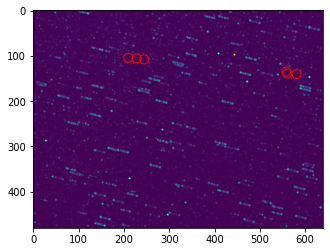

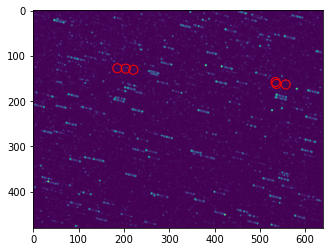

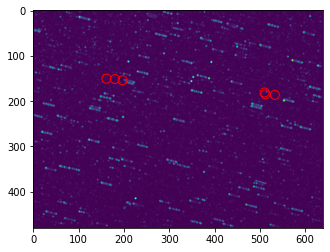

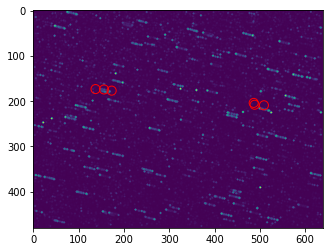

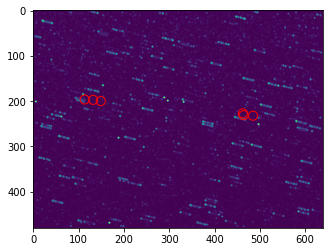

In [94]:
Iouts = []

for frameid in range(0, 5):
    frame = frames[frameid]

    x_in = frame[..., None]
      
    Iout = model.predict(np.array([x_in]))[0, :, :, 0]
    # Iout2 = model2.predict(np.array([x_in]))[0, :, :, 0]
    # Iout4 = model4.predict(np.array([x_in]))[0, :, :, 0]
    
    # Iout = np.mean([Iout2, Iout4], axis=0)
    
    Iout = filters.median(Iout)
    Iouts.append(Iout)

    plt.imshow( morphology.dilation(Iout), vmin=0, vmax=1)
    for x, y in targets[:, frameid]:
        draw_target(plt.gcf().gca(), y, x)
    plt.show()

In [95]:
Ts = evaluate_transforms_to_frame2(Iouts)

registered_frames = [transform.warp(frame, np.linalg.inv(Ti)) for frame, Ti in zip(frames, Ts)]

registered = transform_sequence_to_frame2(Iouts)

Idiffs = []

for frameid in range(0, 5):
    Ibase = np.max([registered[i] for i in range(0, 5) if i != frameid], axis=0)

    Idiff = filters.gaussian(registered[frameid]) - Ibase
    Idiffs.append(Idiff)

0.289065957069397


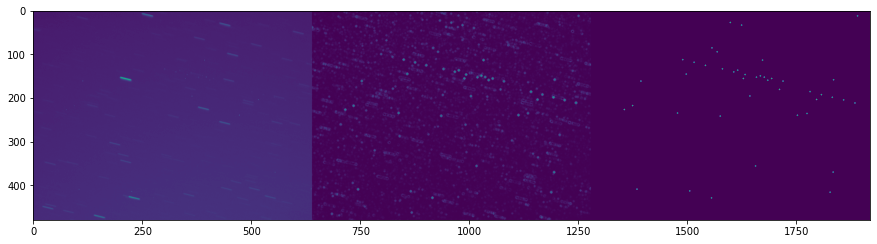

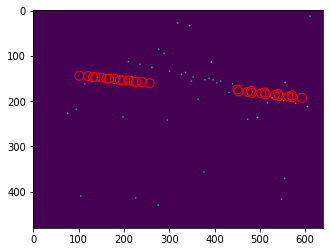

In [96]:
Ts = evaluate_transforms_to_frame2(Iouts)

registered_frames = [transform.warp(frame, np.linalg.inv(Ti)) for frame, Ti in zip(frames, Ts)]

registered = transform_sequence_to_frame2(Iouts)

Iin = np.max(registered_frames, axis=0)
Idiff = np.max([Idiffs[frameid] for frameid in range(0, 5)], axis=0)

print(0.5*Idiff.max())

Iproposal = morphology.h_maxima(Idiff, 0.5*Idiff.max())

plt.figure(figsize=(15, 5))
plt.imshow(np.hstack([Iin, morphology.dilation(Idiff), morphology.dilation(Iproposal)]), vmin=0, vmax=1)
plt.show()


plt.imshow(morphology.dilation(Iproposal))

for frameid in range(0, 5):
    if len(targets) > 0:
        Z = transform.matrix_transform(targets[:, frameid], Ts[frameid])
        for z in Z:
            draw_target(plt.gcf().gca(), z[1], z[0])
            
plt.show()

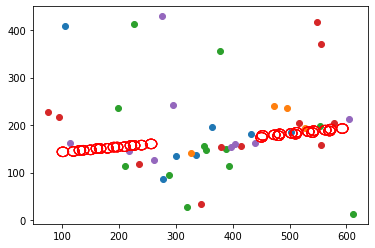

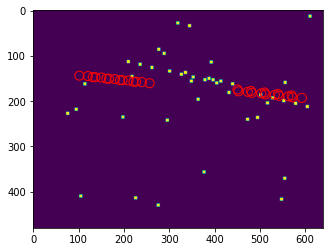

In [97]:
f_coords = []

Iout = np.zeros((480, 640))

for frameid in range(0, 5):
    Idiff = Idiffs[frameid]
    Iproposal = morphology.h_maxima(Idiff, 0.3)
    
    Iout += Iproposal
    
    fi_coords = coords_from_binary(Iproposal)
    f_coords.append( fi_coords )
    
    plt.scatter(fi_coords[:, 0], fi_coords[:, 1])
    
    for frameid in range(0, 5):
        if len(targets) > 0:
            Z = transform.matrix_transform(targets[:, frameid], Ts[frameid])
            for z in Z:
                draw_target(plt.gcf().gca(), z[1], z[0])
    
plt.show()

f_coords = np.array(f_coords)

plt.imshow( morphology.dilation(Iout, morphology.square(7)))
for frameid in range(0, 5):
    if len(targets) > 0:
        Z = transform.matrix_transform(targets[:, frameid], Ts[frameid])
        for z in Z:
            draw_target(plt.gcf().gca(), z[1], z[0])
plt.show()


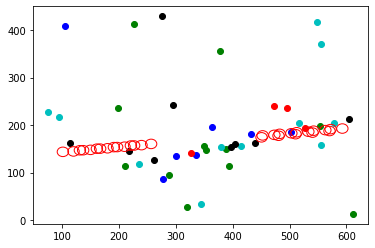

In [98]:
f_coords0 = f_coords[0]
f_coords1 = f_coords[1]
f_coords2 = f_coords[2]
f_coords3 = f_coords[3]
f_coords4 = f_coords[4]

import pickle

pickle.dump(f_coords, open('ds.pkl', 'wb'))
pickle.dump(Ts, open('ts.pkl', 'wb'))

plt.scatter(f_coords0[:, 0], f_coords0[:, 1], c='b')
plt.scatter(f_coords1[:, 0], f_coords1[:, 1], c='r')
plt.scatter(f_coords2[:, 0], f_coords2[:, 1], c='g')
plt.scatter(f_coords3[:, 0], f_coords3[:, 1], c='c')
plt.scatter(f_coords4[:, 0], f_coords4[:, 1], c='k')

for frameid in range(0, 5):
    if len(targets) > 0:
        Z = transform.matrix_transform(targets[:, frameid], Ts[frameid])
        for z in Z:            
            draw_target(plt.gcf().gca(), z[1], z[0])

plt.show()

In [99]:
Z = np.concatenate([transform.matrix_transform(targets[:, frameid], Ts[frameid]) for frameid in range(0, 5)])

Q = np.concatenate([np.c_[frameid*np.ones(len(f_coords[frameid])), f_coords[frameid]] for frameid in range(0, 5)])

idxs = find_targets(Q[:, [1, 2]], Z)

print(Q.shape)

(43, 3)


[  0. 277.  86.] [  1. 327. 141.]
[  0. 301. 134.] [  1. 327. 141.]
[  0. 336. 137.] [  1. 327. 141.]
[  0. 432. 181.] [  1. 473. 240.]
[  0. 502. 186.] [  1. 528. 193.]
[  0. 364. 196.] [  1. 327. 141.]
[  0. 105. 409.] [  1. 327. 141.]


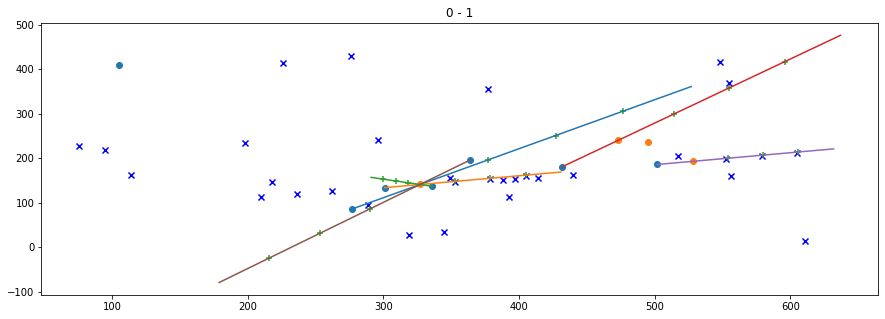

[  1. 327. 141.] [  2. 349. 156.]
[  1. 528. 193.] [  2. 553. 199.]
[  1. 495. 236.] [  2. 553. 199.]
[  1. 473. 240.] [  2. 553. 199.]


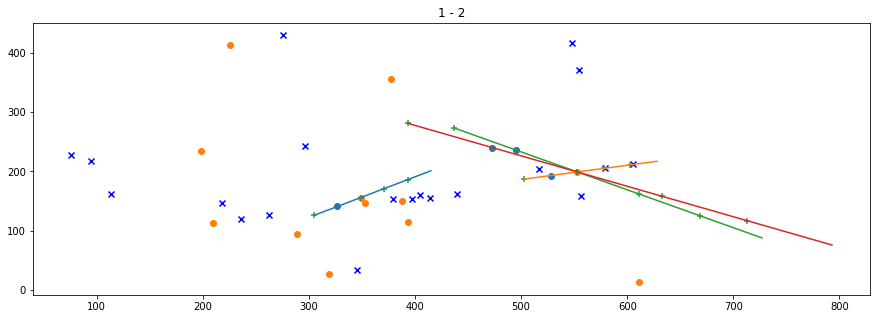

[  2. 611.  13.] [  3. 556. 159.]
[  2. 319.  28.] [  3. 345.  34.]
[  2. 289.  95.] [  3. 236. 119.]
[  2. 210. 113.] [  3. 236. 119.]
[  2. 393. 114.] [  3. 379. 153.]
[  2. 353. 147.] [  3. 379. 153.]
[  2. 388. 150.] [  3. 379. 153.]
[  2. 349. 156.] [  3. 379. 153.]
[  2. 553. 199.] [  3. 579. 205.]
[  2. 198. 235.] [  3.  95. 218.]
[  2. 377. 356.] [  3. 555. 370.]
[  2. 226. 413.] [  3.  95. 218.]


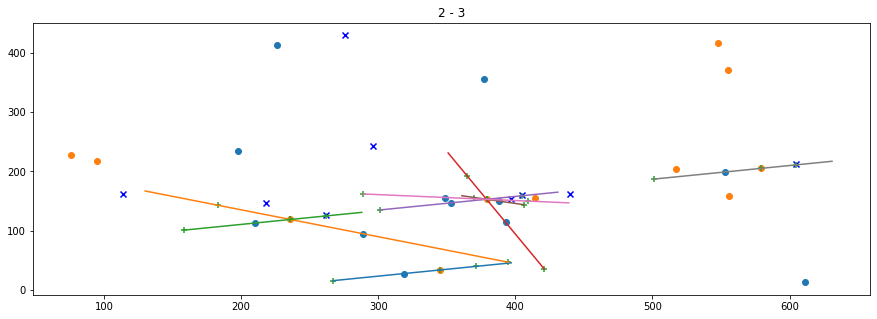

In [100]:
from sklearn.linear_model import LinearRegression

Qscores = np.zeros(len(Q))

ts = [(0, 1), (1, 2), (2, 3)]

lines = []

for t in ts:
    t0, t1 = t
    tc = np.array([q for q in range(0, 5) if q != t0 and q != 1]).reshape(-1, 1)
    
    idx0 = np.where(Q[:, 0] == t0)[0]
    
    c0 = Q[Q[:, 0] == t0]
    c1 = Q[Q[:, 0] == t1]
    
    di = metrics.pairwise_distances_argmin(c0[:, [1, 2]], c1[:, [1, 2]])
    
    plt.figure(figsize=(15, 5))
    
    c_pred = []
    
    for idx, c1_i in zip(idx0, c1[di]):
        c0_i = Q[idx]
        
        print(c0_i, c1_i)
        
        if np.linalg.norm(c0_i[[1, 2]] - c1_i[[1, 2]]) > 100:         
            continue
                
        st = np.stack([c0_i[0], c1_i[0]]).reshape(-1, 1)
        sv = np.c_[c0_i[[1, 2]], c1_i[[1, 2]]].T
        
        lr = LinearRegression().fit(st, sv)
        x_pred = lr.predict(tc)
        
        # Check how well it predicts next points
        score = 0
        for s in range(0, 5):
            ground = Q[Q[:, 0] == s][:, [1, 2]]        
            d = metrics.pairwise_distances(lr.predict([[s]]), ground)        
            score += np.sum(np.min(d, axis=1) < 5)        
        if score > 2:
            lines.append(lr)
        Qscores[idx] += score
        
        c_pred.append(x_pred)
        
        tq = np.linspace(0, 5).reshape(-1, 1) 
        q = lr.predict(tq)
        
        plt.plot(q[:, 0], q[:, 1])
        
    if len(c_pred) > 0:
        c_pred = np.concatenate(c_pred)
    
        plt.scatter(c0[:, 1], c0[:, 2])
        plt.scatter(c1[:, 1], c1[:, 2])
    
        for s in range(t1 + 1, 5):
            plt.scatter(Q[Q[:, 0] == s, 1], Q[Q[:, 0] == s, 2], color='b', marker='x')

        plt.scatter(c_pred[:, 0], c_pred[:, 1], marker='+')
        plt.title(f'{t0} - {t1}')
        

        
    plt.show()

6


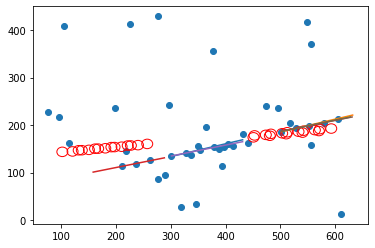

In [101]:
t = np.linspace(0, 5).reshape(-1, 1)

print( len(lines) )

plt.scatter(Q[:, 1], Q[:, 2])
for line in lines:
    y = line.predict(t)
    plt.plot(y[:, 0], y[:, 1])
for frameid in range(0, 5):
    if len(targets) > 0:
        Z = transform.matrix_transform(targets[:, frameid], Ts[frameid])
        for z in Z:            
            draw_target(plt.gcf().gca(), z[1], z[0])
    
plt.show()

6


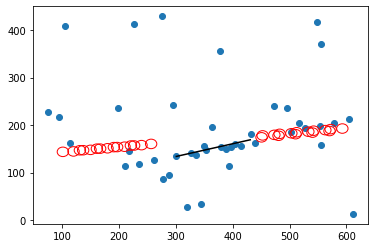

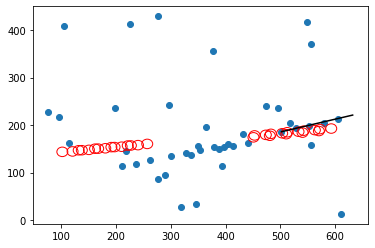

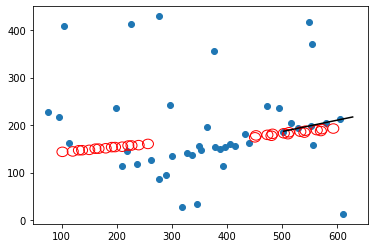

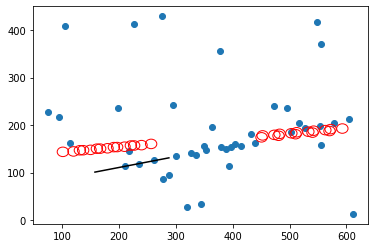

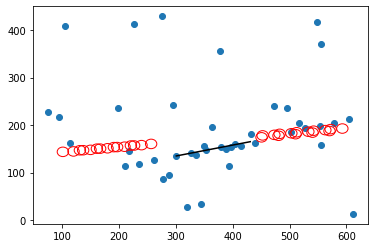

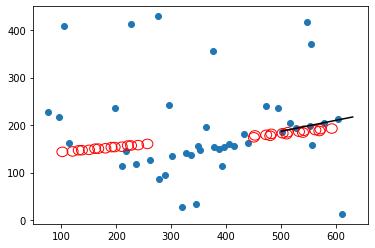

In [102]:
t = np.linspace(0, 5).reshape(-1, 1)

print( len(lines) )

for line in lines:
    plt.scatter(Q[:, 1], Q[:, 2])
    y = line.predict(t)
    plt.plot(y[:, 0], y[:, 1], color='k')
    
    for frameid in range(0, 5):
        if len(targets) > 0:
            Z = transform.matrix_transform(targets[:, frameid], Ts[frameid])
            for z in Z:            
                draw_target(plt.gcf().gca(), z[1], z[0])    
    
    plt.show()

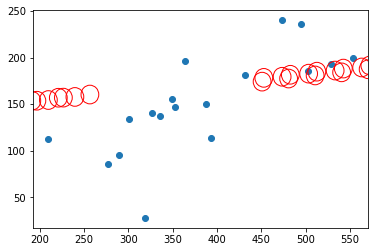

In [103]:
# idxs = np.where(Qscores > 0)[0]



plt.scatter(Q[Qscores > 0, 1], Q[Qscores > 0, 2])
for frameid in range(0, 5):
    if len(targets) > 0:
        Z = transform.matrix_transform(targets[:, frameid], Ts[frameid])
        for z in Z:            
            draw_target(plt.gcf().gca(), z[1], z[0])
plt.show()

(array([ 6, 20, 22, 30, 31, 38, 42]),)


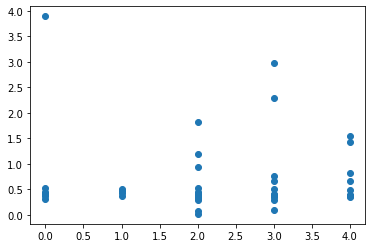

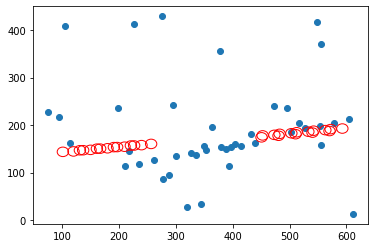

In [104]:
frameid = 0
Q = np.concatenate([np.c_[frameid*np.ones(len(f_coords[frameid])), f_coords[frameid]] for frameid in range(0, 5)])

m = Q[:, 2]/Q[:, 1]

print( np.where(m > 1) )

plt.scatter(Q[:, 0], Q[:, 2]/Q[:, 1])
plt.show()

plt.scatter(Q[:, 1], Q[:, 2])

for frameid in range(0, 5):
    if len(targets) > 0:
        Z = transform.matrix_transform(targets[:, frameid], Ts[frameid])
        for z in Z:            
            draw_target(plt.gcf().gca(), z[1], z[0])
plt.show()

(9, 5, 5)
(9, 25)


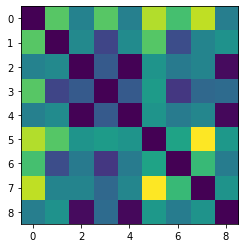

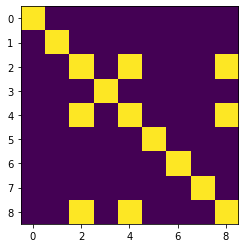

/usr/lib/python3/dist-packages/ipykernel_launcher.py:33: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


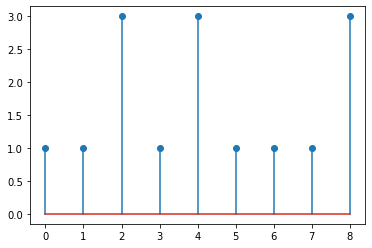

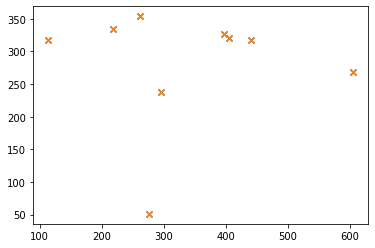

In [105]:
blobs = measure.regionprops(morphology.label(Iproposal > 0), intensity_image=Iin)
coords = np.array([ np.flip(blob.centroid) for blob in blobs ])

radius = 2

regions = [extract_region(Iin, int(r0), int(c0), radius=radius) for c0, r0 in coords]
idxs = [region.shape[0] == region.shape[1] and region.shape[0] != 0 for region in regions]

regions = np.array([regions[i] for i, value in enumerate(idxs) if value])
coords = coords[idxs]

print(regions.shape)

S = regions.reshape(len(regions), -1)

print(S.shape)

d = metrics.pairwise_distances(S, metric='correlation')

plt.imshow(d)
plt.show()

thr = 0.1

plt.imshow(d < 0.1)
plt.show()

count = np.sum(d < thr, axis=1)
mask = count < 5

coords_fil = coords[mask]

plt.stem(count)
plt.show()

plt.scatter(coords[:, 0], 480 - coords[:, 1], marker='x')
plt.scatter(coords_fil[:, 0], 480 - coords_fil[:, 1], marker='x')
plt.show()

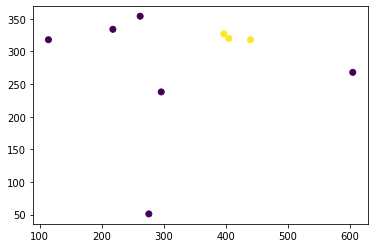

In [106]:
from sklearn.cluster import dbscan

_, labels = dbscan(coords_fil, eps=100, min_samples=3)

plt.scatter(coords_fil[:, 0], 480 - coords_fil[:, 1], c=labels)
plt.show()

n inliers 2


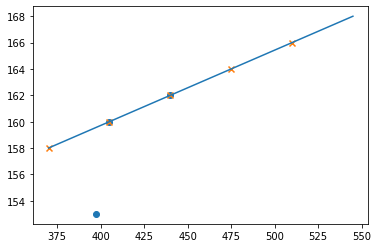

In [107]:
# Check if cluster forms a line
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, LinearRegression
from sklearn.multioutput import MultiOutputRegressor

nclusters = np.max(labels) + 1

for cluster_i in range(nclusters):
    c_coords = coords[labels == cluster_i]
    
    if len(c_coords) > 8:
        # more than one object detected, should return all coordinates
        print(len(c_coords)/5) # crude estimation of the number of objects
        
        t = np.linspace(0, 5, len(c_coords)).reshape(-1, 1)
        lr = MultiOutputRegressor(RANSACRegressor()).fit(t, c_coords)
        
        t1 = np.arange(0, 5).reshape(-1, 1)
        
        plt.scatter(c_coords[:, 0], c_coords[:, 1])
        plt.scatter(lr.predict(t1)[:, 0], lr.predict(t1)[:, 1], marker='x')
        
        plt.show()
        continue
    
    t = np.arange(0, len(c_coords)).reshape(-1, 1)
    
    lr = MultiOutputRegressor(RANSACRegressor()).fit(t, c_coords)
    
    inliers = lr.estimators_[0].inlier_mask_ * lr.estimators_[1].inlier_mask_
    
    score = metrics.mean_squared_error(c_coords[inliers], lr.predict(t[inliers]))
    
    print('n inliers', np.sum(inliers))
    
    t1 = np.linspace(0, 5).reshape(-1, 1)
    t2 = np.arange(0, 5).reshape(-1, 1)
    
    plt.scatter(c_coords[:, 0], c_coords[:, 1])
    plt.plot(lr.predict(t1)[:, 0], lr.predict(t1)[:, 1])
    plt.scatter(lr.predict(t2)[:, 0], lr.predict(t2)[:, 1], marker='x')
    
    plt.show()